## Give me some credit

In [62]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
sns.set_theme(style="darkgrid")

import lightgbm as lgb
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

### Read the input csv files

In [3]:
train = pd.read_csv('data/cs-training.csv')
test = pd.read_csv('data/cs-test.csv')

In [4]:
train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


The first column in the training data has an ambuigous name, therefore, I renamed it to be 'Observation ID'. 

In [5]:
train.rename(columns={'Unnamed: 0': 'ObversationId'}, inplace = True)

### Data Exploration

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ObversationId                         150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

The summary informs me about the missing data. 

In [7]:
pd.DataFrame({"Number of Missing Data":train.isnull().sum(),
             "Ratio":round(train.isnull().sum()/len(train)*100,2)})

,Number of Missing Data,Ratio
ObversationId,0,0.00
SeriousDlqin2yrs,0,0.00
RevolvingUtilizationOfUnsecuredLines,0,0.00
age,0,0.00
NumberOfTime30-59DaysPastDueNotWorse,0,0.00
DebtRatio,0,0.00
MonthlyIncome,29731,19.82
NumberOfOpenCreditLinesAndLoans,0,0.00
NumberOfTimes90DaysLate,0,0.00
NumberRealEstateLoansOrLines,0,0.00


In [8]:
train.describe()

,ObversationId,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


From the above table, we can find out that many values could be a mistake, for example, the minimum age is 0, the maximum debtratio is 329664, and the maximum NumberOfTimes90DaysLate/NumberOfTime60-89DaysPastDueNotWorse are 98. These outliers need to be removed.

I explore each feature by visualization and/or a summary statistics. For example, 

<AxesSubplot: xlabel='NumberOfTime30-59DaysPastDueNotWorse', ylabel='count'>

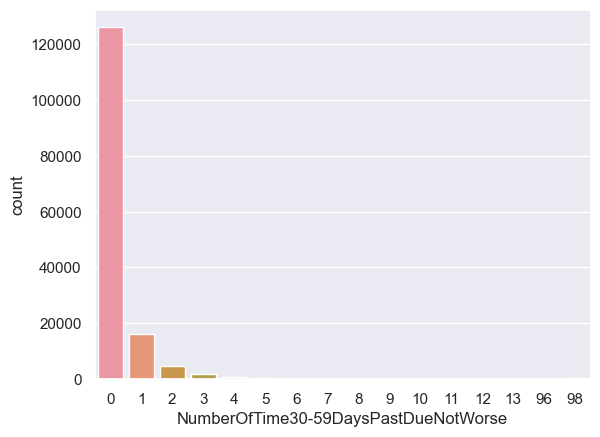

In [15]:
sns.countplot(data = train, x = "NumberOfTime30-59DaysPastDueNotWorse")

<AxesSubplot: xlabel='NumberOfTimes90DaysLate', ylabel='count'>

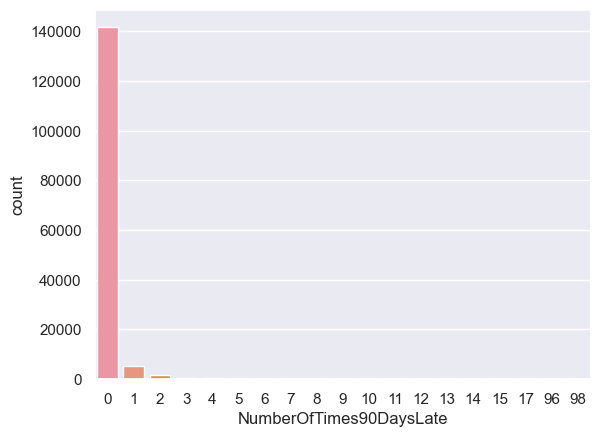

In [17]:
sns.countplot(data = train, x = "NumberOfTimes90DaysLate")

As you can see from the above 2 figures, a majority of users will not pass due without noticing the bank in the past 2 years. There are some obvious outliers, i.e. the 96 and 98 times from both figures. This clearly doesn't make sense as user can't pass due 96 times within 2 years. Therefore, in the following data cleaning part, we also need to deal with outliers. 

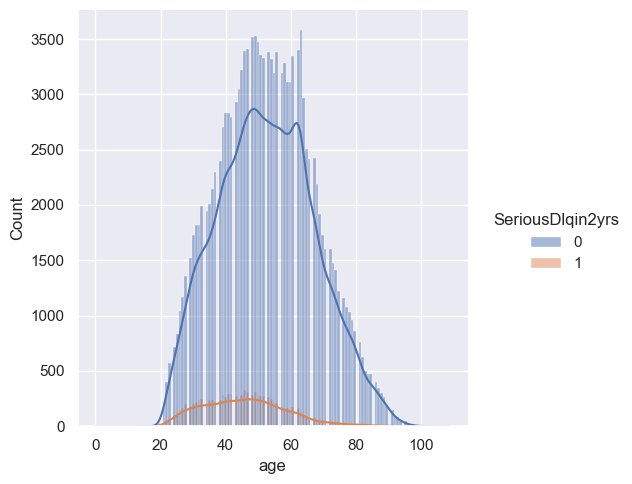

In [19]:
sns.displot(train, x = "age", kde=True, hue= "SeriousDlqin2yrs")

From the above user age distribution by category, it seems that younger users have a higher tendency to experience 90 days past due delinquency or worse. 

### Data Pre-processing

#### Identify Outliers

To have an intuitive understanding of our dataset, I plotted the following visualizations,

<AxesSubplot: xlabel='age'>

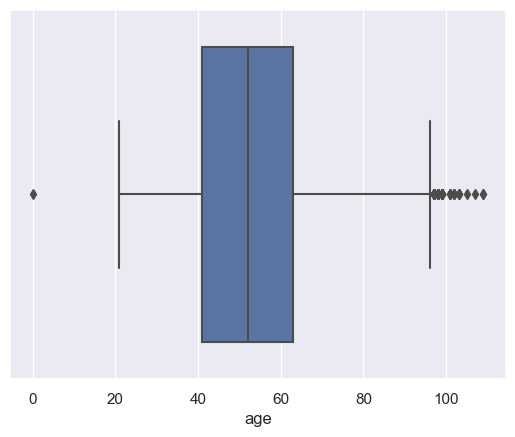

In [35]:
sns.boxplot(data=train, x="age")

<AxesSubplot: xlabel='DebtRatio'>

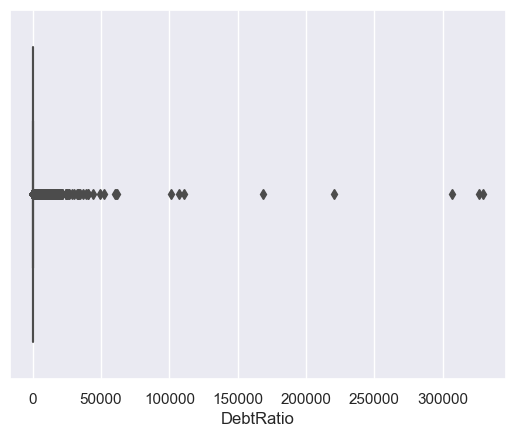

In [36]:
sns.boxplot(data=train, x="DebtRatio")

From the above boxplots, I can identify some outliers within our 150,000 observations. For simplicity, I decided to remove the outliers with Turkey's procedure which could affect the following data analysis. 

In [9]:
indices = []
    
for col in train.columns.values[2:]: 
    
    # calculate IQR
    Q1 = np.percentile(train[col], 25)
    Q3 = np.percentile(train[col],75)
    IQR = Q3 - Q1
    step = 1.5 * IQR
    
    # find the index that contains outliers
    list_col = train[(train[col] < Q1 - step) | (train[col] > Q3 + step )].index
    indices.extend(list_col)
    
# remove the observations when they have 2 or more features that are outliers
indices = Counter(indices) 
outliers = list(k for k, v in indices.items() if v > 2)
print("Number of observations dropped: ", len(outliers))
train = train.drop(train.index[outliers]).reset_index(drop = True)

Number of observations dropped:  3527


#### Missing Values in the data set

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146473 entries, 0 to 146472
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ObversationId                         146473 non-null  int64  
 1   SeriousDlqin2yrs                      146473 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  146473 non-null  float64
 3   age                                   146473 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  146473 non-null  int64  
 5   DebtRatio                             146473 non-null  float64
 6   MonthlyIncome                         118224 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       146473 non-null  int64  
 8   NumberOfTimes90DaysLate               146473 non-null  int64  
 9   NumberRealEstateLoansOrLines          146473 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  146473 non-null  int64  
 11  

From the `info` table, I can find out that the training data has 10 predictors as well as 1 response variables (`SeriousDlqin2yrs`). Most of the features have 146,473 observations after I have dropped the outliers, however, `MonthlyIncome` and `NumberOfDependents` have a noticable amount of missing values. Therefore, I need to properly deal with the missing values for these two columns before progressing to the next step of data analysis. 

As `NumberOfDependents` only have a few (2.6%) missing records and there is no clear pattern between this feature and other selected features, or our response variable, I choose to assign `NumberOfDependents` based on its nearest 5 neighbors. For simplicity, I also used KNN with N = 5 to decide what the missing value should be. 

In [10]:
train['NumberOfDependents'].fillna(0,inplace=True)
imputer = KNNImputer(n_neighbors=5)
train_imputed = imputer.fit_transform(train)
train = pd.DataFrame(train_imputed, columns=train.columns) 

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146473 entries, 0 to 146472
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ObversationId                         146473 non-null  float64
 1   SeriousDlqin2yrs                      146473 non-null  float64
 2   RevolvingUtilizationOfUnsecuredLines  146473 non-null  float64
 3   age                                   146473 non-null  float64
 4   NumberOfTime30-59DaysPastDueNotWorse  146473 non-null  float64
 5   DebtRatio                             146473 non-null  float64
 6   MonthlyIncome                         146473 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       146473 non-null  float64
 8   NumberOfTimes90DaysLate               146473 non-null  float64
 9   NumberRealEstateLoansOrLines          146473 non-null  float64
 10  NumberOfTime60-89DaysPastDueNotWorse  146473 non-null  float64
 11  

Now, the missing data has been properly computed. 

#### Data Imbalance for the response variable

[Text(0, 0, '138176'), Text(0, 0, '8297')]

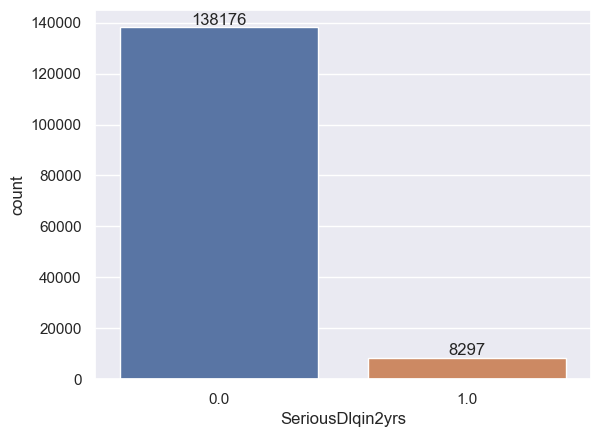

In [41]:
ax = sns.countplot(x=train["SeriousDlqin2yrs"])
ax.bar_label(ax.containers[0])

From the above figure, I discover that there is salient imbalance for the response variable, as a result, we have to apply some resample techniques before analyzing the data.

In [48]:
y = train['SeriousDlqin2yrs']
X = train.drop(['ObversationId', 'SeriousDlqin2yrs'], axis = 1)

X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [13]:
print("Number of Yes: ", sum(y_resampled == 1))
print("Number of No: ", sum(y_resampled == 0))

Number of Yes:  138176
Number of No:  138176


The last step of data preprocessing is to to rescale the features through standardization so that they can have a mean as 0 and variance as 1. 

In [43]:
scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = scaler.transform(X_resampled)

### Data Analysis

Firstly, I fit a logistic regression. Instead of using traditional training and testing split, I choose to use the default `LogisticRegressionCV` function and specifies the `scoring` to be `roc_auc`. AUC is the area under the ROC (Receiver Operating Characteristics) curve. ROC curve has False Positive Rate as its x-axis and True Positive Rate as its y-axis. If the AUC is closer to 1, it means that our model can greatly identify the two classes. On the other hand, if the AUC is closer to 0.5, it means that our model has a poor performance as random guessing would have an auc of 0.5.
- I choose to use the average auc (area under the roc curve) value from 8-fold cross validation as the evaluation criteria. 
- I choose the metric to be auc value over F-1 score, accuracy, precision/recall because it’s the evaluation metric for this challenge. It’s better to keep consistent with the evaluation metric of the stakeholders. 
- I choose to use k-fold cross validation instead of a simple train test split so that my result can be more robust. If only one random seed is chosen and one set of auc score is calculated from one train-test split, the auc score can happen by chance.
- Other metrics that can be suitable for this competition is recall, which is the number of true positive over the sum of true positive and false negative. This is important because for the banks, they want to increase their recall so as to avoid missing the customers who is gonna to experience 90 days past due delinquency or worse. 

#### Logistic regression 

Firstly, we don't consider the interaction effect between the variables. 

In [32]:
clf = LogisticRegressionCV(cv=8, random_state=42, scoring='roc_auc').fit(X_resampled, y_resampled)
clf.score(X_resampled, y_resampled)

0.8406138138272438

Therefore, the average auc score for my logistic regression model is 0.84, which is desirable. Then, I investigate on which individual factors have a higher influence on our response by first calculating the logit odd of our coefficients as follows, 

In [33]:
np.exp(clf.coef_)

array([[0.97582292, 0.63083318, 2.4110578 , 0.90508833, 0.79765914,
        1.06207591, 3.93145483, 1.14172231, 1.98578707, 1.06432825]])

Findings: 
- As the logit odd of the age is 0.63, this means younger people are more likely to experience 90 days past due delinquency or worse. 
- As the logit odd of the number of times borrower has been 30-59 days past due has a logit odd of 2.411, it indicates that users who have past due for no more than 59 days more frequently are more likely to experience 90 days past due delinquency or worse. 
- Similarly, the number of times borrower has been 90 days or more past due. This indicates that users who have past due over 90 days more frequently are more likely to experience 90 days past due delinquency or worse.
- A similar result can be drawn for the number of times borrower has been 60-89 days past due.
- Other factors don't affect the probability of experiencing 90 days past due delinquency or worse as much as the above four factors as other factors have a logit odd value more close to 1. 

Then, I would like to conduct a ploynomial logistic regression up to degree 2 to test the interaction effects among the variables. I used `PolynomialFeatures` package, set the `degree` to be 2 and the `interaction_only` parameter to be True. 

In [56]:
poly = PolynomialFeatures(degree = 2, interaction_only = True)
X_poly = poly.fit_transform(X_resampled)

lr = LogisticRegressionCV(cv=8, random_state=42, scoring='roc_auc', solver = 'sag', max_iter=500).fit(X_poly, y_resampled)

In [59]:
lr.score(X_poly, y_resampled)

0.8430093975763617

In [75]:
coefs = np.exp(lr.coef_)
choice = np.logical_or(np.greater(coefs, 1.3), np.less(coefs, 0.7))
np.extract(choice, coefs)

array([0.66154631, 2.3224084 , 4.34250193, 1.97210232, 0.67471521])

In [74]:
coefs

array([[1.093658  , 1.00459668, 0.66154631, 2.3224084 , 0.84137566,
        0.76693069, 1.06630682, 4.34250193, 1.15928579, 1.97210232,
        1.05070493, 1.0057228 , 0.97531208, 0.92135257, 0.91094172,
        1.04562219, 1.0804524 , 1.01362894, 1.03080965, 0.98600402,
        1.06954276, 0.83961536, 0.86416374, 0.9954921 , 1.1062228 ,
        0.99596643, 1.1103626 , 1.00819084, 1.05849785, 1.02097389,
        0.86452381, 0.67471521, 0.97837699, 0.78198206, 0.96960519,
        1.17694664, 1.09881472, 0.90070742, 1.03877715, 0.96869169,
        0.95615096, 1.07608583, 1.12035032, 1.05284838, 0.94588151,
        0.97907425, 1.17558302, 1.05200773, 0.95777624, 0.97684268,
        1.18940968, 0.78007533, 0.93106354, 1.0327901 , 0.97009891,
        0.99351564]])

Therefore, we can say there are some interaction effects between some of the predictors. 

#### Submission

In [49]:
test = pd.read_csv('data/cs-test.csv')
test.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [50]:
test.rename(columns={'Unnamed: 0': 'ObversationId'}, inplace = True)

In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ObversationId                         101503 non-null  int64  
 1   SeriousDlqin2yrs                      0 non-null       float64
 2   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 3   age                                   101503 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 5   DebtRatio                             101503 non-null  float64
 6   MonthlyIncome                         81400 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 8   NumberOfTimes90DaysLate               101503 non-null  int64  
 9   NumberRealEstateLoansOrLines          101503 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 11  

In [52]:
test = test.drop(['ObversationId', 'SeriousDlqin2yrs'], axis = 1)
test['NumberOfDependents'].fillna(0,inplace=True)
imputer = KNNImputer(n_neighbors=5)
test_imputed = imputer.fit_transform(test)

In [53]:
test = pd.DataFrame(test_imputed, columns=test.columns) 

In [54]:
test.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.885519,43.0,0.0,0.177513,5700.0,4.0,0.0,0.0,0.0,0.0
1,0.463295,57.0,0.0,0.527237,9141.0,15.0,0.0,4.0,0.0,2.0
2,0.043275,59.0,0.0,0.687648,5083.0,12.0,0.0,1.0,0.0,2.0
3,0.280308,38.0,1.0,0.925961,3200.0,7.0,0.0,2.0,0.0,0.0
4,1.000000,27.0,0.0,0.019917,3865.0,4.0,0.0,0.0,0.0,1.0


In [44]:
scaler = StandardScaler()
scaler.fit(test)
test = scaler.transform(test)

In [55]:
y_test_predicted = clf.predict_proba(test)[:,1]

result = pd.read_csv('data/sampleEntry.csv') 
result['Probability'] = y_test_predicted
result.to_csv('data/submit.csv',index=False)

The above estimated probability for logistic regression without considering interaction effect has a private score of 0.766 on Kaggle. Consider that this is the result of logistic regression, it is acceptable. 

In [76]:
poly = PolynomialFeatures(degree = 2, interaction_only = True)
X_poly_test = poly.fit_transform(test)
y_test_predicted = lr.predict_proba(X_poly_test)[:,1]

result = pd.read_csv('data/sampleEntry.csv') 
result['Probability'] = y_test_predicted
result.to_csv('data/submit2.csv',index=False)

The estimated probability for logistic regression witn interaction effect has a private score of 0.753 on Kaggle. 

#### Random Forest

Then, I tried to use tree-based method. Specifially, I used random forest. 

In [95]:
clf = RandomForestClassifier(random_state= 42) 

search_grid = {
        'max_depth': [4, 6, 8, 10],
        'min_samples_leaf': [1, 2, 4, 6],
        'n_estimators': [25, 50, 100, 200], 
        'criterion' :['gini', 'entropy']
}

grid_clf = GridSearchCV(estimator = clf, param_grid = search_grid, cv = 5, verbose=1, scoring='roc_auc')
grid_clf.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'n_estimators': [25, 50, 100, 200]},
             scoring='roc_auc', verbose=1)

In [97]:
# grid_clf.best_estimator_
grid_clf.best_params_
# grid_clf.cv_results_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [55]:
clf = RandomForestClassifier(random_state= 42, max_depth = 10, min_samples_leaf = 1, n_estimators = 100, criterion = 'gini')
clf.fit(X_resampled, y_resampled)
y_test_predicted = clf.predict_proba(test)[:,1]

result = pd.read_csv('data/sampleEntry.csv') 
result['Probability'] = y_test_predicted
result.to_csv('data/submit3.csv',index=False)

The private score for this random forest model is 0.856, which is better than logistic regression, and is closer to the TOP 100 scores (highest: 0.869) on Kaggle.  

#### Light GBM 

Lastly, I would like to try on the performance of light gradient boosting machine. 

In [56]:
clf = lgb.LGBMClassifier(n_estimators=150,colsample_bytree=0.95,subsample=0.95, learning_rate=0.015, metric='auc')

In [46]:
clf.fit(X_resampled, y_resampled)

LGBMClassifier(colsample_bytree=0.95, learning_rate=0.015, n_estimators=150,
               subsample=0.95)

In [47]:
y_test_predicted = clf.predict_proba(test)[:,1]

result = pd.read_csv('data/sampleEntry.csv') 
result['Probability'] = y_test_predicted
result.to_csv('data/submit5.csv',index=False)

In [72]:
clf = lgb.LGBMClassifier(metric='auc')
parameters = {
    'n_estimators': [100, 300, 500],
    'learning_rate':[0.025, 0.015,0.005],
    'max_depth' :[5, 10, 15],
    'min_data_in_leaf':[1, 5, 10],
    'bagging_fraction': [0.6, 0.8],
}

gsearch = GridSearchCV(clf, param_grid = parameters, n_jobs=5, verbose=11)
gsearch.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 5/5; 1/162] START bagging_fraction=0.6, learning_rate=0.025, max_depth=5, min_data_in_leaf=1, n_estimators=100
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[CV 5/5; 1/162] END bagging_fraction=0.6, learning_rate=0.025, max_depth=5, min_data_in_leaf=1, n_estimators=100;, score=0.919 total time=   4.6s
[CV 1/5; 2/162] START bagging_fraction=0.6, learning_rate=0.025, max_depth=5, min_data_in_leaf=1, n_estimators=300
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[CV 1/5; 2/162] END bagging_fraction=0.6, learning_rate=0.025, max_depth=5, min_data_in

GridSearchCV(estimator=LGBMClassifier(metric='auc'), n_jobs=5,
             param_grid={'bagging_fraction': [0.6, 0.8],
                         'learning_rate': [0.025, 0.015, 0.005],
                         'max_depth': [5, 10, 15],
                         'min_data_in_leaf': [1, 5, 10],
                         'n_estimators': [100, 300, 500]},
             verbose=11)

In [73]:
print(gsearch.best_params_)

{'bagging_fraction': 0.6, 'learning_rate': 0.025, 'max_depth': 15, 'min_data_in_leaf': 1, 'n_estimators': 500}


In [74]:
clf = lgb.LGBMClassifier(n_estimator=500, learning_rate = 0.025, max_depth = 15, min_data_in_leaf = 1, 
                         bagging_fraction = 0.6, subsample=0.9, metric='auc')

clf.fit(X_resampled, y_resampled)

y_test_predicted = clf.predict_proba(test)[:,1]

result = pd.read_csv('data/sampleEntry.csv') 
result['Probability'] = y_test_predicted
result.to_csv('data/submit6.csv',index=False)

The private score for this model is 0.863, which is very close to the top answers on Kaggle.  

### Discussions

In summary, with the input data, I first conducted EDA with summary statistics and visualizations. Then, in the data pre-processing stages, I removed the outliers from our dataset, replaced the missing values with values from its nearest neighbors, and standardized all the input features. In the data anlaysis stage, I first tried to fit a logitic regression without considering the interaction effects between the predictors with 8-fold cross validation. The testing AUC is 0.84, while its private performance score on Kaggle is 0.766. 

Some key take-aways for decision makers are: 
1. Younger people are more likely to experience 90 days past due delinquency or worse. 
2. Borrower who have past due for no more than 59 days, 60-89 days, or over 90 days are more frequently are more likely to experience 90 days past due delinquency or worse. 
3. Monthly income, debt ratio, and number of dependents don't have a significant effect on our response variables.

In other words, younger people and people who have past due at the past are more likely to experience 90 days past due delinquency or worse. 

Then, I tried to consider the interaction effects between the predictors by constructing a polynomial logistic regression with up to 2 degrees. Even though the testing AUC improves by 0.005, its private performance score drops by 0.013. Therefore, it might not be a good idea to fit a polynomial logistic regression model on our data set. The potential problem could be overfitting.

Then, I fitted a series of random forests models with `RandomForestClassier` and 5-fold crossvalidation. I used a search grid to alter the parameters for `max_depth`, `min_samples_leaf`, `min_samples_split`, and `n_estimators` for hyperparameter tuning. The private score on Kaggle is 0.856. Compared to logistic regression, this is a big improvement. 

Lastly, I fitted light GBM models on the data set. After hyperparameter tuning, the final model has a private score of 0.863, which is a further improvement compared to the previous two methods.

### Future Improvement

- Currently, I just explored the given features. More insights might be drawn if feature engineering has been conducted. For exmaple, we can get the monthly debt by multiplying monthlyincome with debtratio. The resulting monthly debt might gives us a better understanding of borrowers' behaviors. 

- Due to time limitation, there are other supervised learning models I would like to explore: 
1. XGBoost 
2. Support Vector Machine (SVM)
3. Naive Bayes. 

- To further improve my logistic regression model and random forest model, I should construct confusion matrix for my models in order to investigate if my model have high false positive rate or false negative rate. In this way, I can better improve my model through regularization and hyperparameter tuning. 

- The pre-processing can be improved as well. Currently, it's only a heurisitic to drop all the observations having more than 2 features as an outlier. Another way is to decide how to drop outliers for each feature separately. 

- Some pitfalls I encountered: 
1. It's better to use unscaled data as input for random forest and light GBM. However, other methods like logistic regression assumes the inputs have been scaled. 
2. Polynomial logistic regression fails to converge error. 